In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import os
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math

In [2]:
df_wave = pd.read_csv('raw_data/Zwin_data_wave.csv', index_col='Timestamp')
df_wind = pd.read_csv('raw_data/Zwin_data_wind.csv', index_col = 'Timestamp')
df_tide = pd.read_csv('raw_data/tides_avg.csv', index_col = 'Timestamp')

In [3]:
comb_3 = df_wave.join(df_wind, how='left', on='Timestamp')
comb_3 = comb_3.join(df_tide, how='left', on='Timestamp')


In [4]:
comb = comb_3.dropna()
comb

,wave_height,wave_period,wind_speed,wind_direction,tide
Timestamp,,,,,
2019-02-22 14:00:00+00:00,19.0,3.01,7.0,132.0,464.2
2019-02-22 15:00:00+00:00,18.0,3.29,7.0,125.0,469.0
2019-02-22 16:00:00+00:00,17.0,3.69,8.0,116.0,416.5
2019-02-22 17:00:00+00:00,14.0,3.75,8.0,106.0,329.3
2019-02-22 18:00:00+00:00,11.0,3.54,9.0,96.0,223.9
...,...,...,...,...,...
2022-05-28 17:00:00+00:00,55.0,3.51,25.0,353.0,69.8
2022-05-28 18:00:00+00:00,58.0,3.44,25.0,356.0,71.1
2022-05-28 19:00:00+00:00,67.0,3.37,22.0,357.0,117.9


In [5]:

bins = [0, 11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75, 360]
labels=['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
comb['wind_direction_cat'] = pd.cut(comb['wind_direction'], bins=bins, labels=labels, include_lowest=True, ordered=False)
comb

/var/folders/2z/7f2tkw5n0xn9n2y28g_v96600000gn/T/ipykernel_99321/1721789044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['wind_direction_cat'] = pd.cut(comb['wind_direction'], bins=bins, labels=labels, include_lowest=True, ordered=False)


,wave_height,wave_period,wind_speed,wind_direction,tide,wind_direction_cat
Timestamp,,,,,,
2019-02-22 14:00:00+00:00,19.0,3.01,7.0,132.0,464.2,SE
2019-02-22 15:00:00+00:00,18.0,3.29,7.0,125.0,469.0,SE
2019-02-22 16:00:00+00:00,17.0,3.69,8.0,116.0,416.5,ESE
2019-02-22 17:00:00+00:00,14.0,3.75,8.0,106.0,329.3,ESE
2019-02-22 18:00:00+00:00,11.0,3.54,9.0,96.0,223.9,E
...,...,...,...,...,...,...
2022-05-28 17:00:00+00:00,55.0,3.51,25.0,353.0,69.8,N
2022-05-28 18:00:00+00:00,58.0,3.44,25.0,356.0,71.1,N
2022-05-28 19:00:00+00:00,67.0,3.37,22.0,357.0,117.9,N


In [6]:
bins = [0, 200, 300, 900]
labels=[1,2,3]
comb['tide_cat'] = pd.cut(comb['tide'], bins=bins, labels=labels, include_lowest=True, ordered=False)
comb

/var/folders/2z/7f2tkw5n0xn9n2y28g_v96600000gn/T/ipykernel_99321/2620439370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['tide_cat'] = pd.cut(comb['tide'], bins=bins, labels=labels, include_lowest=True, ordered=False)


,wave_height,wave_period,wind_speed,wind_direction,tide,wind_direction_cat,tide_cat
Timestamp,,,,,,,
2019-02-22 14:00:00+00:00,19.0,3.01,7.0,132.0,464.2,SE,3
2019-02-22 15:00:00+00:00,18.0,3.29,7.0,125.0,469.0,SE,3
2019-02-22 16:00:00+00:00,17.0,3.69,8.0,116.0,416.5,ESE,3
2019-02-22 17:00:00+00:00,14.0,3.75,8.0,106.0,329.3,ESE,3
2019-02-22 18:00:00+00:00,11.0,3.54,9.0,96.0,223.9,E,2
...,...,...,...,...,...,...,...
2022-05-28 17:00:00+00:00,55.0,3.51,25.0,353.0,69.8,N,1
2022-05-28 18:00:00+00:00,58.0,3.44,25.0,356.0,71.1,N,1
2022-05-28 19:00:00+00:00,67.0,3.37,22.0,357.0,117.9,N,1


In [7]:
ohe = OneHotEncoder(sparse = False)
wind_encoded = ohe.fit_transform(comb[['wind_direction_cat']])
comb[ohe.categories_[0]]= wind_encoded
comb

/Users/riotvan/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,wave_height,wave_period,wind_speed,wind_direction,tide,wind_direction_cat,tide_cat,E,ENE,ESE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-22 14:00:00+00:00,19.0,3.01,7.0,132.0,464.2,SE,3,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 15:00:00+00:00,18.0,3.29,7.0,125.0,469.0,SE,3,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 16:00:00+00:00,17.0,3.69,8.0,116.0,416.5,ESE,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 17:00:00+00:00,14.0,3.75,8.0,106.0,329.3,ESE,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 18:00:00+00:00,11.0,3.54,9.0,96.0,223.9,E,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-28 17:00:00+00:00,55.0,3.51,25.0,353.0,69.8,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-28 18:00:00+00:00,58.0,3.44,25.0,356.0,71.1,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-28 19:00:00+00:00,67.0,3.37,22.0,357.0,117.9,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
scaler = RobustScaler()
scaler_m = MinMaxScaler()
comb['wave_height'] = scaler.fit_transform(comb[['wave_height']])
comb['wave_period'] = scaler.fit_transform(comb[['wave_period']])
comb['wind_speed'] = scaler_m.fit_transform(comb[['wind_speed']])
comb

/var/folders/2z/7f2tkw5n0xn9n2y28g_v96600000gn/T/ipykernel_99321/1633312342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['wave_height'] = scaler.fit_transform(comb[['wave_height']])
/var/folders/2z/7f2tkw5n0xn9n2y28g_v96600000gn/T/ipykernel_99321/1633312342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['wave_period'] = scaler.fit_transform(comb[['wave_period']])
/var/folders/2z/7f2tkw5n0xn9n2y28g_v96600000gn/T/ipykernel_99321/1633312342.py:5: SettingWithCopyWarning: 
A value is trying

,wave_height,wave_period,wind_speed,wind_direction,tide,wind_direction_cat,tide_cat,E,ENE,ESE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-22 14:00:00+00:00,-0.500000,-0.736264,0.088235,132.0,464.2,SE,3,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 15:00:00+00:00,-0.526316,-0.428571,0.088235,125.0,469.0,SE,3,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 16:00:00+00:00,-0.552632,0.010989,0.102941,116.0,416.5,ESE,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 17:00:00+00:00,-0.631579,0.076923,0.102941,106.0,329.3,ESE,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-22 18:00:00+00:00,-0.710526,-0.153846,0.117647,96.0,223.9,E,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-28 17:00:00+00:00,0.447368,-0.186813,0.352941,353.0,69.8,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-28 18:00:00+00:00,0.526316,-0.263736,0.352941,356.0,71.1,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-28 19:00:00+00:00,0.763158,-0.340659,0.308824,357.0,117.9,N,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
comb['tide'].values

array([464.2, 469. , 416.5, ..., 117.9, 164.9, 229.8])

In [10]:
!pwd

/Users/riotvan/code/christinehick/SurfWaves


In [11]:
# def tide_cat(num):
#     if num < 200:
#         return 1
#     elif num >= 200 and num < 300:
#         return 2
#     else:
#         return 3
# def trans_func(df):
#     return df.apply(lambda x: [tide_cat(num) for num in x])
# def cos_list(df):
#     return np.cos(df.apply(lambda x: [2 * math.pi * float(num) / 360  for num in x]))
# def sin_list(df):
#     return np.sin(df.apply(lambda x: [2 * math.pi * float(num) / 360  for num in x]))


In [12]:
from SurfWaves.utils import trans_func, cos_list,sin_list

In [35]:
from sklearn.compose import make_column_transformer
num_transformer = RobustScaler()
custom_tr = FunctionTransformer(trans_func)
cycle_tr_sin = FunctionTransformer(sin_list)
cycle_tr_cos = FunctionTransformer(cos_list)

preprocessor_tr = make_column_transformer(
    (num_transformer, ['wave_period', 'wind_speed']),
    #(num_transformer, ['wave_height', 'wave_period', 'wind_speed']),
    (custom_tr, ['tide']),
    (cycle_tr_sin, ['wind_direction']),
    (cycle_tr_cos, ['wind_direction']),
    remainder='passthrough'
    )   


pipe_preproc = Pipeline([
    ('preproc', preprocessor_tr),
    ('imputer', IterativeImputer())
])
pipe_preproc


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['wave_period',
                                                   'wind_speed']),
                                                 ('functiontransformer-1',
                                                  FunctionTransformer(func=<function trans_func at 0x29f3644c0>),
                                                  ['tide']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function sin_list at 0x29f3643a0>),
                                                  ['wind_direction']),
                                                 ('functiontransformer-3',
                                                  FunctionTransformer(func=<function cos_list at 0x29f364430>),
                                                  ['wind_direction'])])),
                ('imputer', IterativeImputer())])

In [49]:
df_new_test = pd.read_csv('raw_data/DePanne_combined.csv', index_col='Timestamp')
df_new_test.dropna()

,wave_height,wave_period,wind_direction,wind_speed,tide
Timestamp,,,,,
2014-01-01 00:00:00+00:00,36.0,2.69,6.59,218.0,434.2
2014-01-01 00:30:00+00:00,43.0,2.60,6.98,215.0,416.1
2014-01-01 01:00:00+00:00,42.0,2.67,6.58,204.0,390.0
2014-01-01 01:30:00+00:00,44.0,3.05,6.46,196.0,355.8
2014-01-01 02:00:00+00:00,43.0,2.91,7.12,195.0,316.7
...,...,...,...,...,...
2021-12-30 22:00:00+00:00,62.0,3.25,6.94,217.0,434.3
2021-12-30 22:30:00+00:00,53.0,3.17,6.41,212.0,416.0
2021-12-30 23:00:00+00:00,51.0,3.18,6.32,209.0,393.0


<AxesSubplot:xlabel='wave_height', ylabel='Count'>

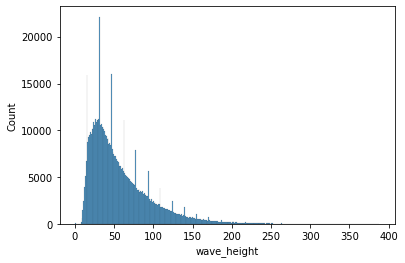

In [61]:
sns.histplot(df_new_test['wave_height'])

In [37]:
comb_3

,wave_height,wave_period,wind_speed,wind_direction,tide
Timestamp,,,,,
2019-02-22 13:30:00+00:00,19.0,2.83,NaN,NaN,423.8
2019-02-22 14:00:00+00:00,19.0,3.01,7.0,132.0,464.2
2019-02-22 14:30:00+00:00,21.0,3.31,NaN,NaN,478.2
2019-02-22 15:00:00+00:00,18.0,3.29,7.0,125.0,469.0
2019-02-22 15:30:00+00:00,17.0,3.61,NaN,NaN,447.6
...,...,...,...,...,...
2022-05-28 22:00:00+00:00,84.0,3.56,NaN,NaN,342.6
2022-05-28 22:30:00+00:00,86.0,3.63,NaN,NaN,400.7
2022-05-28 23:00:00+00:00,93.0,3.74,NaN,NaN,433.5


In [38]:
preproc_model = pipe_preproc.fit(comb_3)
preproc_model_dp = pipe_preproc.fit(df_new_test)


In [46]:
import pickle
with open("raw_data/pipeline_3.pkl", "wb") as file:
    pickle.dump(preproc_model, file)


In [45]:

with open("raw_data/pipeline_2.pkl", "wb") as file:
    pickle.dump(preproc_model_dp, file)


In [43]:
pd.DataFrame(preproc_model_dp.transform(df_new_test))

,0,1,2,3,4,5
0,-1.056818,-0.075937,3.0,0.101745,0.994640,22.0
1,-0.943182,-0.084571,3.0,0.099635,0.994842,22.0
2,-0.852273,-0.089585,3.0,0.098764,0.994884,23.0
3,-0.954545,-0.081815,3.0,0.100663,0.994703,23.0
4,-0.829545,-0.091312,3.0,0.098342,0.994925,23.0
...,...,...,...,...,...,...
675787,-0.079545,0.083333,3.0,0.120830,0.992673,62.0
675788,-0.170455,0.051282,3.0,0.111642,0.993748,53.0
675789,-0.159091,0.032051,3.0,0.110081,0.993923,51.0
675790,-0.227273,0.044872,3.0,0.114937,0.993373,51.0


In [41]:


yug = pipe_preproc.transform(comb_3)

pd.DataFrame(yug)


,0,1,2,3,4,5
0,-0.556818,-0.119605,3.0,0.090012,0.995881,19.0
1,-0.352273,-1.262821,3.0,0.743145,-0.669131,19.0
2,-0.011364,-0.157263,3.0,0.081519,0.996612,21.0
3,-0.034091,-1.262821,3.0,0.819152,-0.573576,18.0
4,0.329545,-0.190735,3.0,0.071923,0.997689,17.0
...,...,...,...,...,...,...
56922,0.272727,-0.059612,3.0,0.127712,0.989666,84.0
56923,0.352273,-0.061871,3.0,0.127869,0.989571,86.0
56924,0.477273,-0.058120,3.0,0.131267,0.988965,93.0
56925,0.534091,-0.070007,3.0,0.126945,0.989538,89.0


In [19]:
print(type(preproc_model))

<class 'sklearn.pipeline.Pipeline'>


In [20]:
# pipe = Pipeline([
#     ('preproc', pipe_preproc),
#     'model', Ridge()])
# pipe

In [21]:
#model = pipe.fit(comb_3, 'dummy')
#prediction = model.predict('dummy_test')
